In [122]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

### Read data

In [123]:
# Read data
uncertainty = pd.read_csv('../data/processed/uncertainty_index.csv')

# Semiconductor ETF price
etf_price = pd.read_csv('../data/processed/etf_price.csv')

In [124]:
etf_price

,Period,etf_price
0,2010-01-01,12.225553
1,2010-02-01,13.201204
2,2010-03-01,14.057395
3,2010-04-01,14.341842
4,2010-05-01,13.403166
...,...,...
166,2023-11-01,170.488037
167,2023-12-01,191.216141
168,2024-01-01,194.902161
169,2024-02-01,216.865021


In [125]:
# Merge
data = pd.merge(uncertainty,etf_price,on='Period')

# Set 'period' as the index
data.set_index('Period', inplace=True)

# Create a new column 'y_diff' representing the difference (lagged by 1 period) of ip
data['etf_price_diff'] = data['etf_price'].diff()
data.dropna(inplace=True)

# Create a new column 'etf_price_diff_abs' representing the absolute value of the difference
data['etf_price_diff_abs'] = data['etf_price_diff'].abs()


In [126]:
data

,uncertainty,etf_price,etf_price_diff,etf_price_diff_abs
Period,,,,
2010-08-01,0.557530,11.762784,-1.374280,1.374280
2010-09-01,0.058235,13.517061,1.754277,1.754277
2010-10-01,0.261647,14.451340,0.934279,0.934279
2010-11-01,0.010756,15.157042,0.705702,0.705702
2010-12-01,0.018884,15.914191,0.757149,0.757149
...,...,...,...,...
2023-04-01,0.445942,136.125839,-10.375199,10.375199
2023-05-01,0.236691,157.449371,21.323532,21.323532
2023-06-01,0.477267,167.543045,10.093674,10.093674


### STNSU & ETF

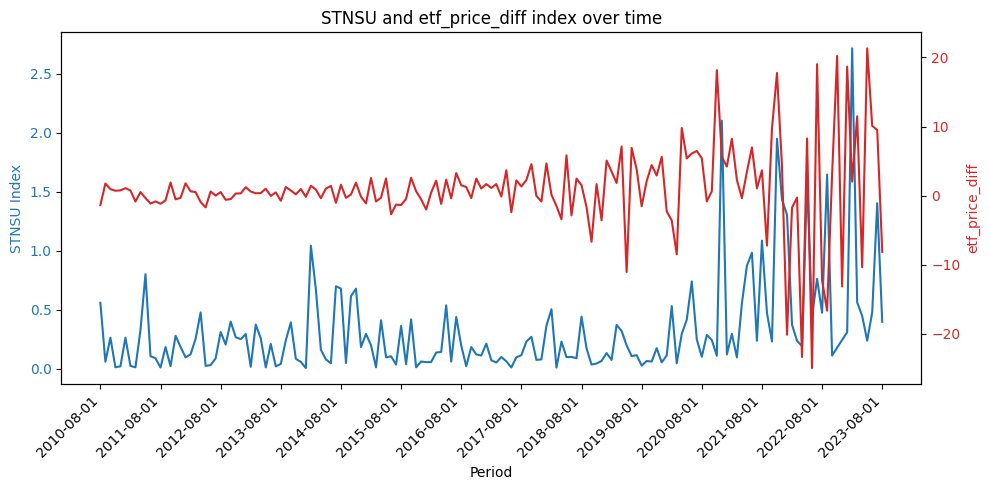

In [127]:

# Plotting
fig, ax1 = plt.subplots(figsize=(10, 5))

# Plot the first time series on the left y-axis (ax1)
color = 'tab:blue'
ax1.set_xlabel('Period')
ax1.set_ylabel('STNSU Index', color=color)
ax1.plot(data.index, data['uncertainty'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Create a second y-axis (ax2) on the right
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('etf_price_diff', color=color)
ax2.plot(data.index, data['etf_price_diff'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

# Set x-axis ticks at intervals of 12 periods and rotate x-labels
ax1.set_xticks(data.index[::12])
ax1.set_xticklabels(data.index[::12], rotation=45, ha='right')

# Show the plot
plt.title('STNSU and etf_price_diff index over time')
plt.tight_layout() 
plt.show()


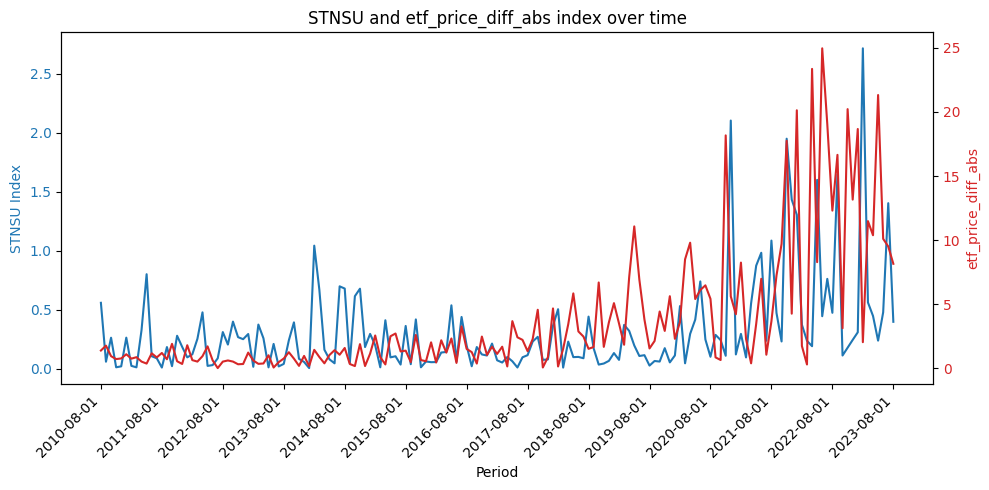

In [128]:

# Plotting
fig, ax1 = plt.subplots(figsize=(10, 5))

# Plot the first time series on the left y-axis (ax1)
color = 'tab:blue'
ax1.set_xlabel('Period')
ax1.set_ylabel('STNSU Index', color=color)
ax1.plot(data.index, data['uncertainty'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Create a second y-axis (ax2) on the right
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('etf_price_diff_abs', color=color)
ax2.plot(data.index, data['etf_price_diff_abs'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

# Set x-axis ticks at intervals of 12 periods and rotate x-labels
ax1.set_xticks(data.index[::12])
ax1.set_xticklabels(data.index[::12], rotation=45, ha='right')

# Show the plot
plt.title('STNSU and etf_price_diff_abs index over time')
plt.tight_layout() 
plt.show()


### Model


In [129]:
# Set target and feature data
Y = data['etf_price_diff_abs']
X = data['uncertainty']


In [130]:
from scipy.stats import pearsonr

correlation, p_value = pearsonr(X, Y)
print(f"Correlation: {correlation}, p-value: {p_value}")

# Positive Correlation: The correlation coefficient is significantly positive, X and Y move together in the same direction.

Correlation: 0.301510020239359, p-value: 0.00012433699389354308


Granger Causality Test

In [131]:
from statsmodels.tsa.stattools import grangercausalitytests

# Prepare data
data_for_test = data[['etf_price_diff_abs', 'uncertainty']].dropna()

# Perform Granger Causality Test
max_lag = 1
gc_test = grangercausalitytests(data_for_test, max_lag, verbose=True)

# The output will provide F-statistics and p-values for each lag.
# confirms that X has predictive power over Y



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.2453  , p=0.0234  , df_denom=153, df_num=1
ssr based chi2 test:   chi2=5.3482  , p=0.0207  , df=1
likelihood ratio test: chi2=5.2585  , p=0.0218  , df=1
parameter F test:         F=5.2453  , p=0.0234  , df_denom=153, df_num=1


/Users/ouharuhua/anaconda3/envs/Code_for_thesis/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


Vector Autoregression (VAR)

In [132]:
from statsmodels.tsa.api import VAR

# Prepare data
data_var = data[['etf_price_diff_abs', 'uncertainty']].dropna()

# Fit VAR model
model = VAR(data_var)
results = model.fit(maxlags=1, ic='aic')

# Check the summary
print(results.summary())

# Forecasting
forecast = results.forecast(data_var.values[-results.k_ar:], steps=10)


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 30, Jul, 2024
Time:                     13:51:02
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    1.11625
Nobs:                     156.000    HQIC:                   1.04659
Log likelihood:          -514.627    FPE:                    2.71545
AIC:                     0.998950    Det(Omega_mle):         2.61395
--------------------------------------------------------------------
Results for equation etf_price_diff_abs
                           coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------------------
const                         1.463484         0.482888            3.031           0.002
L1.etf_price_diff_abs         0.444189         0.072630            6.116           0.000
L1.uncertainty 

/Users/ouharuhua/anaconda3/envs/Code_for_thesis/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


ADL model

In [133]:
def lag_list(Y, X, p=1, q=0):

    ADLx = pd.DataFrame()
    T = len(Y)
    ADLy = list(Y[max(p, q):T])
    for i in range(1, p+1):
        name = f'y_{i}'
        ADLx[name] = list(Y[max(p, q)-i:T-i])
    for i in range(1, q+1):
        name = f'x_{i}'
        ADLx[name] = list(X[max(p, q)-i:T-i])
        
    return ADLy, ADLx
    

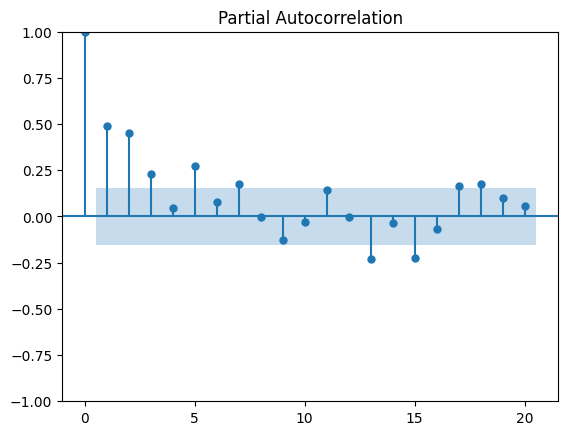

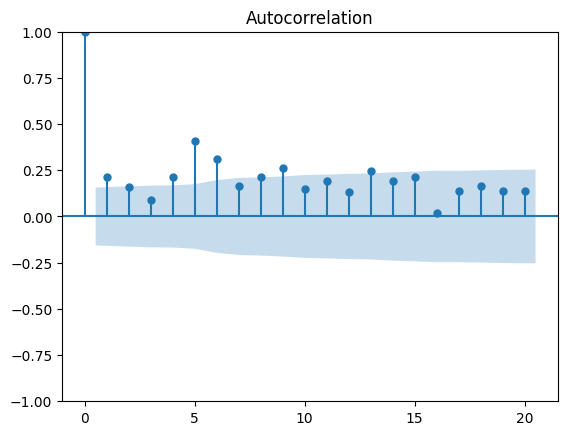

In [134]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

plot_pacf(Y, lags=20)
plt.show()  # for p: p = 4

plot_acf(X, lags=20)
plt.show() # for q: q=2


In [149]:
# Model 
ADLy1, ADLx1 = lag_list(Y, X, p=1, q=1)
ADLx1 = sm.add_constant(ADLx1)
mod1 = sm.OLS(ADLy1, ADLx1)
res1 = mod1.fit()

print("Summary for Model:")
print(res1.summary())

# lagged values of both Y and X have a meaningful impact on the current value of Y.
# Recent changes in X (uncertainty) have a direct and impactful role on Y (ETF price fluctuation). 

Summary for Model:
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.269
Model:                            OLS   Adj. R-squared:                  0.259
Method:                 Least Squares   F-statistic:                     28.09
Date:                Tue, 30 Jul 2024   Prob (F-statistic):           4.06e-11
Time:                        13:56:54   Log-Likelihood:                -452.41
No. Observations:                 156   AIC:                             910.8
Df Residuals:                     153   BIC:                             920.0
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.4635      0.483 